<a href="https://colab.research.google.com/github/aryski/IML_test_generation/blob/main/Adam_Ryski_IML_test_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
author: Adam Ryski
title: Question Generation & Evaluation Notebook
---

# Question Generation and Evaluation

This notebook demonstrates how to generate and evaluate questions over text excerpts using a variety of large language models.

You can get files generated by this notebook here:
https://drive.google.com/drive/folders/1NR0eCdVcuXvU_tj5txXgQ_rooyrXuqhz



## Workflow

1. **Generate Questions**  
   First, questions are generated from the input excerpt.

2. **Evaluate Questions**  
   Generated questions are scored along six metrics:

| Metric                 | Description                                            | Scale                                                                                                                                                           |
|:-----------------------|:-------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Cognitive Level**    | Bloom’s Taxonomy level                                 | 1 = Remember/Understand<br>2 = Apply<br>3 = Analyze<br>4 = Evaluate<br>5 = Create                                                                              |
| **Relevance**          | How well the question pertains to the excerpt          | 1 = None<br>2 = Slight<br>3 = Moderate<br>4 = High<br>5 = Fully addressed                                                                                        |
| **Difficulty**         | Overall challenge level of the question                | 1 = Easiest<br>2 = Easy<br>3 = Moderate<br>4 = Difficult<br>5 = Hardest                                                                                          |
| **Dependency**         | Number of knowledge domains required to answer         | 1 = Single narrow domain<br>2 = Two closely related domains<br>3 = Two distinct domains<br>4 = Three domains<br>5 = Four or more domains                         |
| **Ambiguousness**      | Clarity of wording                                     | 1 = Clear<br>2 = Mostly clear<br>3 = Some ambiguity<br>4 = Highly ambiguous<br>5 = Very ambiguous                                                                |
| **Context Dependency** | Portion of the excerpt needed to answer                | 1 = ≤20%<br>2 = 21–40%<br>3 = 41–60%<br>4 = 61–80%<br>5 = 81–100%                                                                                                  |

> **Tip:**  
> Adjust the metric weights at the end of the notebook to select the best questions for any given excerpt.

---

## What’s Interesting?

- Compare LLM performance on question generation versus evaluation.
- Analyze strengths and weaknesses across the six metrics.

---

## Models Used

- **o4-mini**  
- **o3**  
- **grok-3-beta**  
- **claude-3-7-sonnet-20250219**

---

## Customization

At the end of the notebook, specify weights for each metric (for example, emphasize relevance or difficulty). The notebook will then rank and select the top-scoring questions.

---

*Happy exploring!*  


# Setup

### Dependencies

In [ ]:
!pip install -q openai pandas openpyxl seaborn

In [ ]:
!pip freeze > requirements.txt

### Imports

In [ ]:
import csv
import json
import openai
import pandas as pd

### Secrets

In [ ]:
from google.colab import userdata
# TODO Set your own keys in secrets
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
XAI_API_KEY = userdata.get('XAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

# Quiz Generation
Input data containing study materials should be passed in the excerpts.xslx file.

In [ ]:
import os

def load_excerpts_from_excel(file_path: str = "excerpts.xlsx") -> list:
    """Load excerpts from an Excel file."""
    try:
        df = pd.read_excel(file_path)
        return df['excerpt'].dropna().tolist() if 'excerpt' in df.columns else df.iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"Error loading excerpts: {e}")
        return []

excerpts = load_excerpts_from_excel()

Question generation parameters

In [ ]:
COURSE_TOPIC = "Introduction to Machine Learning"
NUM_OF_QUESTIONS_PER_EXCERPT = 10

### Generation

The first prompt dedicated to question generation is using 6 metrics described in the prompt. My inital approach was to generate questions first and then answers but after some tries I realized that the best way to persuade model to generate questions suitable for ABCD test is by.. Making him generate answers in the same prompt.

In [ ]:
# Content of the question generating prompt
question_generation_prompt_template_ver1 = """
You are an expert assessment author in {course_topic}.
You will be shown an EXCERPT and must craft **{n_questions} diverse, high-quality non open questions (the questions will have generated answers and students will have to choose the correct one)** that will later be graded by an automated rubric (metrics described below).

────────────────────────────────────────────────────────
EXCERPT
────────────────────────────────────────────────────────
{text_excerpt}

────────────────────────────────────────────────────────
SCORING RUBRIC (for later evaluation; do not output any scores now)
────────────────────────────────────────────────────────
1. cognitive_level  (Bloom's Taxonomy — higher is better)
   1 = Remember / Understand │ 2 = Apply │ 3 = Analyze │ 4 = Evaluate │ 5 = Create

2. relevance  (answerable from the excerpt alone)
   1 = None │ 2 = Slight │ 3 = Moderate │ 4 = High │ 5 = Fully addressed

3. difficulty  (overall challenge, incl. language complexity)
   1 = Easiest │ 2 = Easy │ 3 = Moderate │ 4 = Difficult │ 5 = Hardest

4. dependency  (breadth of knowledge areas or sub-areas required)
   1 = Single narrow domain │ 2 = Two related domains │ 3 = Two distinct domains
   4 = Three domains │ 5 = Four+ domains / highly interdisciplinary

5. ambiguousness  (clarity of wording — lower is better)
   1 = Clear, one meaning │ 2 = Mostly clear │ 3 = Some ambiguity
   4 = Highly ambiguous │ 5 = Very ambiguous

6. context_dependency  (portion of excerpt needed to answer)
   1 = ≤20% │ 2 = 21–40% │ 3 = 41–60% │ 4 = 61–80% │ 5 = 81–100%

────────────────────────────────────────────────────────
AUTHORING REQUIREMENTS
────────────────────────────────────────────────────────
● **Cognitive Level** – every question must target ≥ level-3; include at least one level-3, one level-4, and one level-5.
● **Relevance** – all questions must be answerable from the excerpt alone.
● **Difficulty** – vary across the set (some medium, some more challenging).
● **Dependency** – include a mix:
    – one single-domain question
    – one two-distinct-domain question
    – optionally one interdisciplinary question
● **Ambiguousness** – wording must be unambiguous (keep ambiguity low).
● **Context Dependency** – vary how much of the excerpt is needed.
● Keep each question ≤ 40 words.
● For each question, provide four answer options labeled A, B, C, D.
● Ensure that the incorrect options (distractors) are plausible but clearly incorrect based on the excerpt.
● Indicate the correct answer by specifying the letter (A, B, C, or D).

────────────────────────────────────────────────────────
OUTPUT FORMAT (return exactly one JSON array — no extra text)
────────────────────────────────────────────────────────
[
  {{
    "question": "<your first question text>",
    "options": {{
      "A": "<option A text>",
      "B": "<option B text>",
      "C": "<option C text>",
      "D": "<option D text>"
    }},
    "correct_answer": "A"
  }},
  … repeat until Q{n_questions} …
]

Important: output **only** the JSON array, nothing else.
"""

In [ ]:
def generate_questions(template: str, excerpt: str, model: str, client: openai.OpenAI) -> list:
    print(f"Generating questions with OpenAI API using model: {model}")
    """Generate questions using OpenAI API with the stored API key."""
    prompt = template.format(
        course_topic=COURSE_TOPIC,
        n_questions=NUM_OF_QUESTIONS_PER_EXCERPT,
        text_excerpt=excerpt
    )
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
        )
        content = response.choices[0].message.content.strip()
        return json.loads(content)
    except Exception as e:
        print(f"Error with generating questions: {e}")
        return []

def generate_and_save_questions(template: str, out_fn: str, client: openai.OpenAI, model: str):
    if not excerpts:
        print("No excerpts found.")
        return

    all_results = []
    for i, excerpt in enumerate(excerpts, start=1):
        print(f"\n--- Excerpt {i} ---")
        print(excerpt[:200].replace("\n", " ") + "…\n")
        questions = generate_questions(template, excerpt, model, client)
        if not questions:
            print("No questions generated.")
            continue

        for q in questions:
            entry = {
                "model": model,
                "excerpt_id": i,
                "question": q["question"],
                "option_A": q["options"]["A"],
                "option_B": q["options"]["B"],
                "option_C": q["options"]["C"],
                "option_D": q["options"]["D"],
                "correct_answer": q["correct_answer"]
            }
            all_results.append(entry)
            print(f"{q['question']}")

    # Save to CSV
    keys = ["model", "excerpt_id", "question", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
    with open(out_fn, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(all_results)

    print(f"\nSaved {len(all_results)} questions to {out_fn}")

In [ ]:
generate_and_save_questions(
    question_generation_prompt_template_ver1,
    "questions_o4-mini.csv",
    openai.OpenAI(api_key=OPENAI_API_KEY),
    "o4-mini",
)


--- Excerpt 1 ---
Resampling methods are an indispensable tool in modern statistics. They involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain addit…

Generating questions with OpenAI API using model: o4-mini
Which of the following is not a step in the resampling process described?
Which primary benefit of resampling methods is highlighted in the excerpt?
According to the excerpt, the claim 'Resampling always reduces model bias' is:
Which computational challenge arises when using resampling methods?
Which scenario best illustrates a novel application of resampling to estimate model uncertainty?
How can computation of multiple model fits in resampling be accelerated?
How could an instructor use resampling to teach students about model uncertainty?
What is the correct order of operations in the resampling workflow described?
Compared to fitting a model once, resampling provides:
Which option illustrates applying the e

In [ ]:
generate_and_save_questions(
    question_generation_prompt_template_ver1,
    "questions_o3.csv",
    openai.OpenAI(api_key=OPENAI_API_KEY),
    "o3",
)


--- Excerpt 1 ---
Resampling methods are an indispensable tool in modern statistics. They involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain addit…

Generating questions with OpenAI API using model: o3
Which feature most directly characterizes the resampling procedure described in the excerpt?
Why might an analyst prefer resampling over a single model fit, according to the passage?
Suppose you repeatedly refit a linear regression on multiple draws from the same training data. Which insight, emphasized in the excerpt, are you hoping to gain?
Which action would NOT meet the excerpt’s definition of resampling?
Evaluate the following statement: “Resampling is unnecessary when one linear regression fit already captures the underlying relationship.”
You must design a procedure for estimating model stability consistent with the excerpt. Which sequence best satisfies this goal?
The excerpt implies that resampling can unco

In [ ]:
generate_and_save_questions(
    question_generation_prompt_template_ver1,
    "questions_grok-3-beta.csv",
    openai.OpenAI(api_key=XAI_API_KEY, base_url="https://api.x.ai/v1"),
    "grok-3-beta",
)


--- Excerpt 1 ---
Resampling methods are an indispensable tool in modern statistics. They involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain addit…

Generating questions with OpenAI API using model: grok-3-beta
What is the primary purpose of resampling methods in statistics?
How do resampling methods help in estimating variability of a model?
What can resampling reveal about a linear regression fit?
Why might resampling provide more information than a single fit?
What process is central to resampling methods in model analysis?
How does resampling impact the understanding of model stability?
What advantage does resampling offer over a single model fit?
Evaluate the effectiveness of resampling for model assessment.
Analyze why resampling is indispensable in modern statistics.
Design a resampling approach to assess linear regression variability.

--- Excerpt 2 ---
An alternative to LOOCV is k-fold CV. This approach i

In [ ]:
generate_and_save_questions(
    question_generation_prompt_template_ver1,
    "questions_claude-3-7-sonnet-20250219.csv",
    openai.OpenAI(api_key=ANTHROPIC_API_KEY, base_url="https://api.anthropic.com/v1/"),
    "claude-3-7-sonnet-20250219",
)


--- Excerpt 1 ---
Resampling methods are an indispensable tool in modern statistics. They involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain addit…

Generating questions with OpenAI API using model: claude-3-7-sonnet-20250219
What is the primary purpose of resampling methods according to the excerpt?
How could resampling methods help evaluate the stability of a prediction model?
Why might a researcher prefer resampling over fitting a model just once with the original training data?
Analyze the relationship between model variability assessment and resampling as presented in the excerpt.
When implementing linear regression with resampling, what comparison would provide the most insight about model stability?
Which statistical concept most directly connects to the resampling process described?
Design a resampling approach to assess potential model overfitting in a regression context.
What methodological limitation is

### Merge questions

In [ ]:
csv_files = [
    'questions_claude-3-7-sonnet-20250219.csv',
    'questions_grok-3-beta.csv',
    'questions_o3.csv',
    'questions_o4-mini.csv'
]

questions = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
questions.insert(0, 'id', range(1, len(questions) + 1))

questions.to_csv('questions.csv', index=False)

# Quiz evaluation
Quiz evaluation is done by letting each model generate evaluation of every previously generated question. The goal is to make the evaluation more just by distributing the responsibility and power of judgment across many models.

In [ ]:
questions= pd.read_csv('questions.csv')

In [ ]:
# Content of the question evaluation prompt
evaluation_prompt_v1="""
You are an expert in educational assessment.  Below is one EXCERPT.
Evaluate each question on these six metrics (integers 1–5):

1. cognitive_level      – Bloom's Taxonomy (1=Remember/Understand, 2=Apply, 3=Analyze, 4=Evaluate, 5=Create)
2. relevance            – How fully the excerpt answers the question (1=None, 2=Slight, 3=Moderate, 4=High, 5=Fully addressed)
3. difficulty           – Overall challenge (1=Easiest, 2=Easy, 3=Moderate, 4=Difficult, 5=Hardest)
4. dependency           – Breadth of knowledge needed (1=Single domain, 2=Two related, 3=Two distinct, 4=Three, 5=Four+)
5. ambiguousness        – Clarity of wording (1=Clear, 2=Mostly clear, 3=Some ambiguity, 4=Highly ambiguous, 5=Very ambiguous)
6. context_dependency   – Portion of excerpt needed (1=≤20%, 2=21–40%, 3=41–60%, 4=61–80%, 5=81–100%)

EXCERPT:
────────────────────────────────
{excerpt}

**Output**: ONLY a JSON array of objects, one per question, in this exact form:
[
  {{
    "id": <question_id>,
    "cognitive_level": <int>,
    "relevance": <int>,
    "difficulty": <int>,
    "dependency": <int>,
    "ambiguousness": <int>,
    "context_dependency": <int>
  }},
  …
]
No extra keys, no commentary, no markdown—just the array.
"""

In [ ]:
import json, time, pandas as pd, openai

def evaluate_questions_and_save(
    questions: pd.DataFrame,
    template: str,
    out_fn: str,
    evaluation_model: str,
    client: openai.OpenAI,
    pause: float = 0.1
):
    """
    Sends one chat call per excerpt (bundling all its questions).
    Writes out_fn with columns:
      evaluation_model, question_id, cognitive_level, relevance,
      difficulty, dependency, ambiguousness, context_dependency
    """
    graded = []

    # questions and excerpts are captured from outer scope
    for ex_id, group in questions.groupby("excerpt_id", sort=True):
        excerpt_text = excerpts[int(ex_id) - 1]

        # format system prompt with this excerpt
        system_prompt = template.format(excerpt=excerpt_text)

        # assemble user content: all questions for this excerpt
        user_lines = ["QUESTIONS:"]
        for _, r in group.iterrows():
            user_lines += [
                f"id: {int(r['id'])}",
                f"Q: {r['question']}",
                f"A: {r['option_A']}",
                f"B: {r['option_B']}",
                f"C: {r['option_C']}",
                f"D: {r['option_D']}",
                f"Correct: {r['correct_answer']}",
                ""
            ]
        user_content = "\n".join(user_lines).strip()

        # single API call
        try:
            resp = client.chat.completions.create(
                model    = evaluation_model,
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user",   "content": user_content}
                ],
            )
            results = json.loads(resp.choices[0].message.content)
        except Exception as e:
            print(f"[ERROR] excerpt {ex_id}: {e}")
            time.sleep(pause)
            continue

        # collect each question’s metrics
        for obj in results:
            graded.append({
                "evaluation_model"     : evaluation_model,
                "question_id"       : int(obj["id"]),
                "cognitive_level"   : obj["cognitive_level"],
                "relevance"         : obj["relevance"],
                "difficulty"        : obj["difficulty"],
                "dependency"        : obj["dependency"],
                "ambiguousness"     : obj["ambiguousness"],
                "context_dependency": obj["context_dependency"],
            })

        time.sleep(pause)

    # save to CSV
    out_df = pd.DataFrame(graded)
    out_df.to_csv(out_fn, index=False, encoding="utf-8")
    print(f"✅  Wrote {len(out_df)} rows → {out_fn}")

In [ ]:
evaluate_questions_and_save(
    questions,
    evaluation_prompt_v1,
    "evaluation_o4-mini.csv",
    evaluation_model="o4-mini",
    client=openai.OpenAI(api_key=OPENAI_API_KEY)
)

✅  Wrote 160 rows → evaluation_o4-mini.csv


In [ ]:
evaluate_questions_and_save(
    questions,
    evaluation_prompt_v1,
    "evaluation_o3.csv",
    evaluation_model="o3",
    client=openai.OpenAI(api_key=OPENAI_API_KEY)
)

✅  Wrote 160 rows → evaluation_o3.csv


In [ ]:
evaluate_questions_and_save(
    questions,
    evaluation_prompt_v1,
    "evaluation_grok-3-beta.csv",
    evaluation_model="grok-3-beta",
    client=openai.OpenAI(api_key=XAI_API_KEY, base_url="https://api.x.ai/v1")
)

[ERROR] excerpt 2: Expecting value: line 315 column 28 (char 5707)
✅  Wrote 120 rows → evaluation_grok-3-beta.csv


In [ ]:
evaluate_questions_and_save(
    questions,
    evaluation_prompt_v1,
    "evaluation_claude-3-7-sonnet-20250219.csv",
    evaluation_model="claude-3-7-sonnet-20250219",
    client=openai.OpenAI(api_key=ANTHROPIC_API_KEY, base_url="https://api.anthropic.com/v1/")
)

✅  Wrote 160 rows → evaluation_claude-3-7-sonnet-20250219.csv


In [ ]:
csv_files = [
    'evaluation_claude-3-7-sonnet-20250219.csv',
    'evaluation_grok-3-beta.csv',
    'evaluation_o3.csv',
    'evaluation_o4-mini.csv'
]

evaluation = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
evaluation.insert(0, 'id', range(1, len(evaluation) + 1))

evaluation.to_csv('evaluation.csv', index=False)

Evaluation comparison

In [ ]:
evaluation = pd.read_csv('evaluation.csv')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_question_radars(question_ids):
    """
    For each question_id in question_ids, generates a separate radar chart
    showing all evaluation_models' scores across the six metrics.
    Assumes a DataFrame `evaluation` exists in the notebook scope.
    """
    df = evaluation

    metrics = [
        'cognitive_level',
        'relevance',
        'difficulty',
        'dependency',
        'ambiguousness',
        'context_dependency'
    ]
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]

    n_cols = 3
    n_rows = (len(question_ids) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, min(len(question_ids), n_cols),
                             subplot_kw={'projection': 'polar'},
                             figsize=(15, 5*n_rows))

    if n_rows == 1:
        axes = np.array([axes]) if len(question_ids) > 1 else np.array([[axes]])
    elif len(question_ids) == 1:
        axes = np.array([[axes]])

    colors = ['#6BAED6', '#FDBB84', '#9ECAE1', '#A8DDB5']

    for idx, qid in enumerate(question_ids):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 or n_cols > 1 else axes[0]

        subset = df[df['question_id'] == qid]
        if subset.empty:
            print(f"⚠️ No evaluation data found for question_id={qid}")
            continue

        for i, (_, row_data) in enumerate(subset.iterrows()):
            values = [row_data[m] for m in metrics]
            values += values[:1]
            color = colors[i % len(colors)]
            model_name = row_data['evaluation_model']
            label = model_name[:11] + '...' if len(model_name) > 11 else model_name
            ax.plot(angles, values, label=label, color=color, zorder=1)
            ax.fill(angles, values, color=color, alpha=0.3, zorder=1)

        ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
        for label in ax.get_xticklabels():
            label.set_zorder(10)
        ax.set_title(f"Question {qid}", y=1.1)
        ax.set_ylim(1, 5)
        ax.set_yticks([1, 2, 3, 4, 5])
        ax.set_yticklabels(['1', '2', '3', '4', '5'])
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    for idx in range(len(question_ids), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

#### Evaluation comparison
Here we can observe how different are the evaluations of the models using same evaluation criteria.

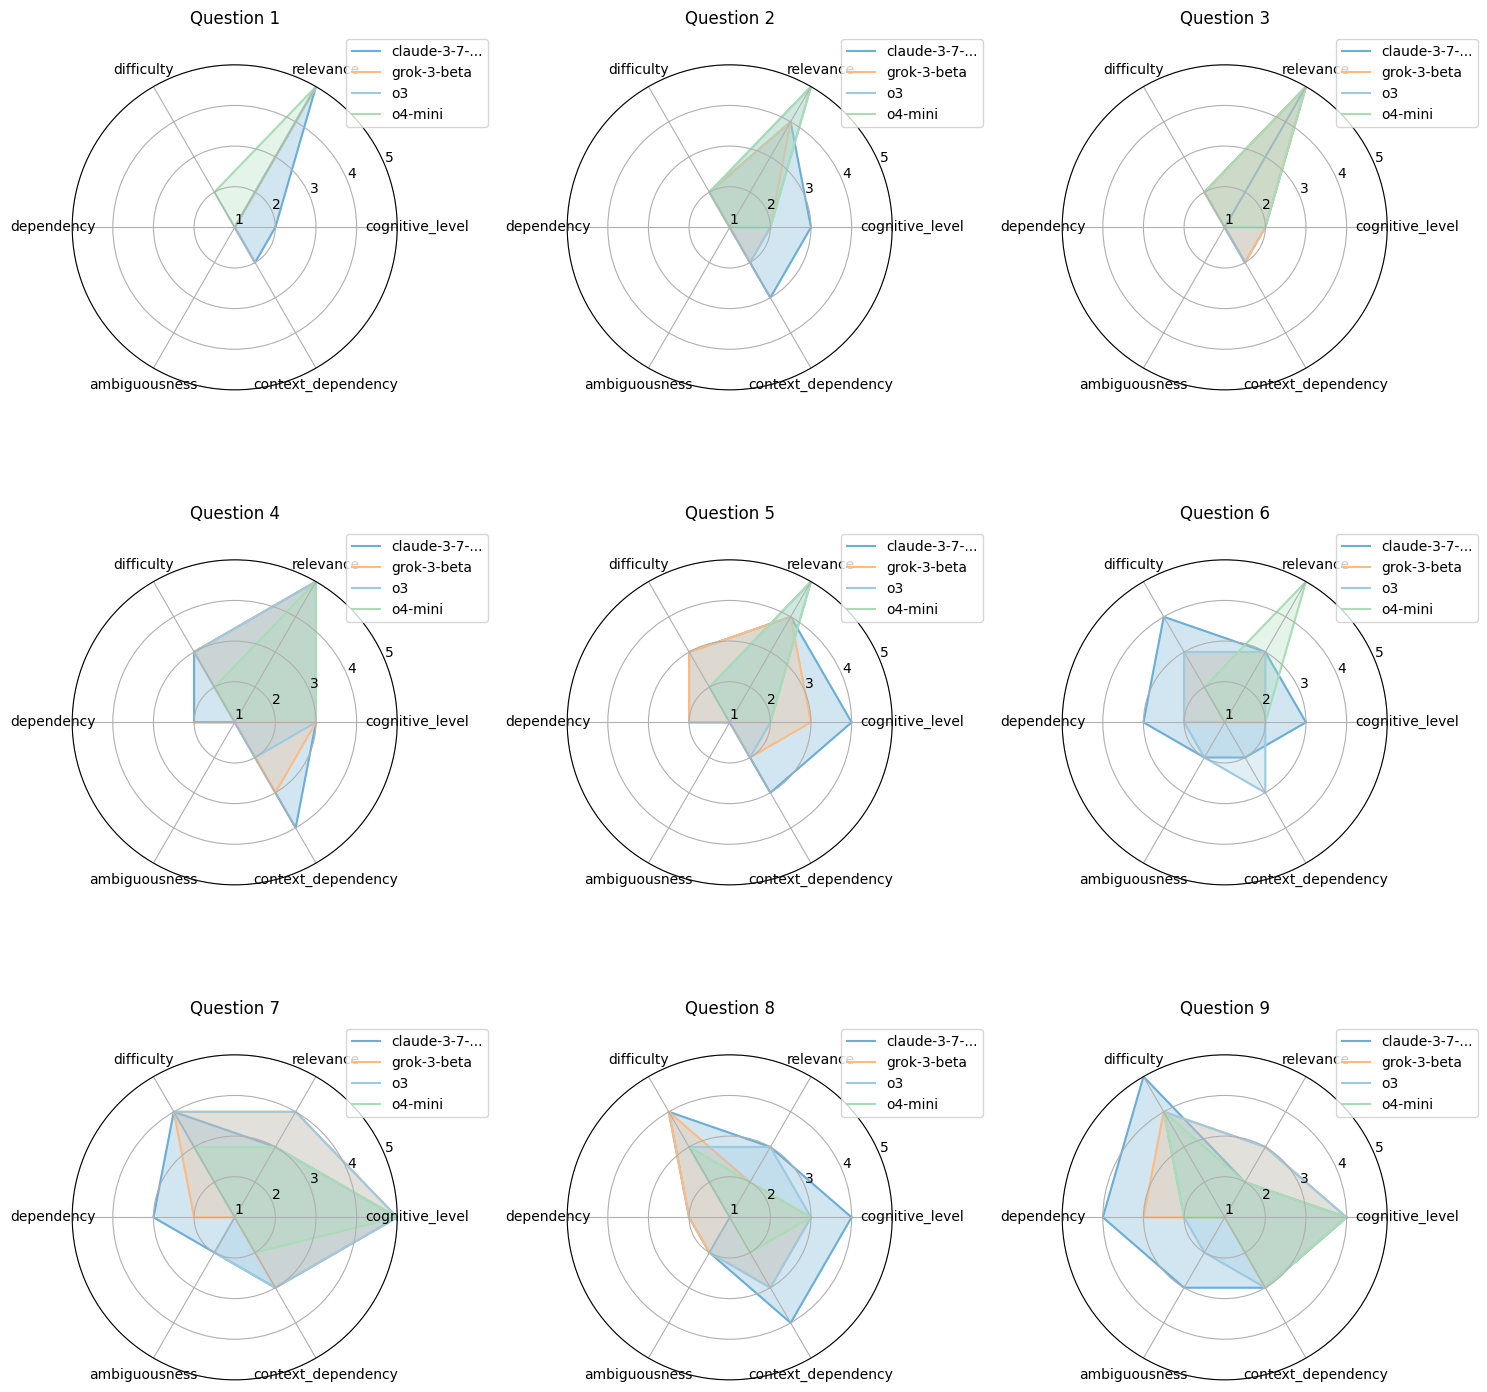

In [ ]:
plot_question_radars(range(1, 10)) # Adjust ids of the questions you'd like to see comparison for

For each evaluation metric we calculated the means for each model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_mean_radars(evaluation):
    """
    Generates a single radar chart showing the mean score across all questions
    for each evaluation_model across the six metrics.
    Assumes a DataFrame `evaluation` exists in the notebook scope.
    """
    df = evaluation

    metrics = [
        'cognitive_level',
        'relevance',
        'difficulty',
        'dependency',
        'ambiguousness',
        'context_dependency'
    ]
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

    colors = ['#6BAED6', '#FDBB84', '#9ECAE1', '#A8DDB5']
    model_means = df.groupby('evaluation_model')[metrics].mean().reset_index()

    for idx, (_, row_data) in enumerate(model_means.iterrows()):
        values = [row_data[m] for m in metrics]
        values += values[:1]
        color = colors[idx % len(colors)]
        model_name = row_data['evaluation_model']
        label = model_name[:11] + '...' if len(model_name) > 11 else model_name
        ax.plot(angles, values, label=label, color=color, zorder=1)
        ax.fill(angles, values, color=color, alpha=0.3, zorder=1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    for label in ax.get_xticklabels():
        label.set_zorder(10)
    ax.set_title("Mean Metrics by Model doing evaluation", y=1.1)
    ax.set_ylim(1, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()

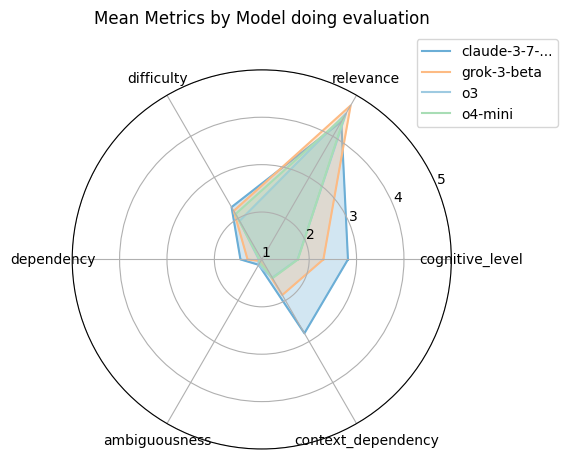

In [ ]:
plot_model_mean_radars(evaluation)

Result on the ambiguousness, and relevance metric is satisfactory however, the results on cognitive level is quite disappointing. That's why we're going to try to modify the prompt to generate questions with higher cognitive level, and more varying difficulty, and dependency and context_dependency.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_question_model_mean_radars(questions, evaluation):
    """
    Generates a radar chart showing the mean score across all questions
    for each question-generating model across six metrics.

    Parameters:
    questions (pd.DataFrame): DataFrame with columns 'id' and 'model'.
    evaluation (pd.DataFrame): DataFrame with columns 'question_id' and metrics:
        cognitive_level, relevance, difficulty, dependency, ambiguousness, context_dependency.
    """
    # Select only 'id' and 'model' from questions
    df = pd.merge(evaluation, questions[['id', 'model']],
                  left_on='question_id', right_on='id', how='inner')

    metrics = [
        'cognitive_level',
        'relevance',
        'difficulty',
        'dependency',
        'ambiguousness',
        'context_dependency'
    ]
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

    # Color palette for different models
    colors = ['#6BAED6', '#FDBB84', '#9ECAE1', '#A8DDB5', '#FF9896', '#C5B0D5']
    model_means = df.groupby('model')[metrics].mean().reset_index()

    for idx, (_, row_data) in enumerate(model_means.iterrows()):
        values = [row_data[m] for m in metrics]
        values += values[:1]  # Close the loop for radar chart
        color = colors[idx % len(colors)]
        model_name = row_data['model']
        # Truncate long model names for readability
        label = model_name[:11] + '...' if len(model_name) > 11 else model_name
        ax.plot(angles, values, label=label, color=color, linewidth=2, zorder=1)
        ax.fill(angles, values, color=color, alpha=0.3, zorder=1)

    # Set metric labels at appropriate angles
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    for label in ax.get_xticklabels():
        label.set_zorder(10)

    # Configure chart
    ax.set_title("Mean Metrics by Question-Generating Model", y=1.1, fontsize=12)
    ax.set_ylim(1, 5)  # Rubric scores range from 1 to 5
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

    plt.tight_layout()
    plt.show()

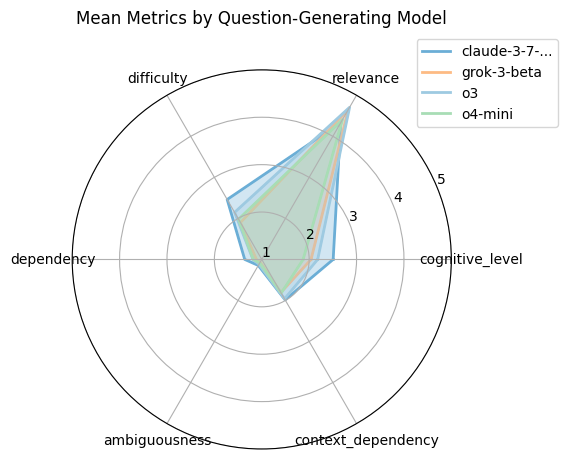

In [ ]:
plot_question_model_mean_radars(questions, evaluation)

# Selecting best questions

In [ ]:
mean_scores = evaluation.groupby('question_id')[['cognitive_level', 'relevance', 'difficulty',
                                                'dependency', 'ambiguousness', 'context_dependency']].mean().reset_index()
questions_scored = pd.merge(questions, mean_scores, left_on='id', right_on='question_id', how='left')
questions_scored = questions_scored.drop(columns=['question_id'])
questions_scored.to_csv('questions_scored.csv', index=False)

In [ ]:
questions_scored

## Example selection of best questions

The `select_top_questions` function is designed to select the best questions from each excerpt in a `questions_scored` DataFrame, based on a list of desired difficulty levels (e.g., `[3, 2, 2, 1]`). It ensures no duplicate questions are selected and prioritizes questions based on high relevance, high cognitive level, low ambiguousness, and moderate dependency and context dependency.

**Process Overview**

1. **Grouping and Difficulty Rounding**:
   - Questions are grouped by `excerpt_id`.
   - Difficulty scores are rounded to the nearest integer (e.g., 2.6 → 3).

2. **Question Selection per Difficulty Level**:
   - For each excerpt and target difficulty level (e.g., 3, 2, 2, 1), the function:
     - Filters out previously selected questions to avoid duplicates.
     - Applies fallback logic to find eligible questions:
       - Tries the target difficulty.
       - If no questions match, tries one difficulty level higher, then lower (down to 1, up to 5).
       - If no questions are found, selects any available question.

3. **Scoring Mechanism**:
   - Eligible questions are scored by summing the following metrics:
     - **Relevance**: Scored from 1 to 5.
     - **Cognitive Level**: Scored from 1 to 5.
     - **Ambiguousness Adjustment**: Calculated as `6 - ambiguousness` (lower ambiguousness yields higher scores).
     - **Dependency Bonus**:
       - 2 if `dependency = 3`.
       - 1 if `dependency = 2 or 4`.
       - 0 otherwise.
     - **Context Dependency Bonus**:
       - 2 if `context_dependency = 3`.
       - 1 if `context_dependency = 2 or 4`.
       - 0 otherwise.

4. **Selection and Output**:
   - The highest-scoring question for each target difficulty is selected.
   - Selected questions are tracked to prevent duplicates.
   - Results are saved to `selected_questions.csv`.

In [ ]:
import pandas as pd
import numpy as np

def select_top_questions(questions_scored, difficulty_levels):
    """
    Selects questions from each excerpt based on specified difficulty levels.

    Parameters:
    - questions_scored (pd.DataFrame): DataFrame with questions and mean metric scores.
    - difficulty_levels (list): List of desired difficulty levels (e.g., [3, 2, 2, 1]).

    Returns:
    - pd.DataFrame: Selected questions meeting the criteria.
    """
    # Round difficulty to nearest integer (e.g., 2.6 -> 3, 2.4 -> 2)
    questions_scored = questions_scored.copy()
    questions_scored['difficulty_rounded'] = questions_scored['difficulty'].round().astype(int)

    def get_candidates(available, target_difficulty):
        """Helper function to apply fallback logic for selecting candidates."""
        # Ensure target_difficulty is within valid range (1-5)
        target_difficulty = max(1, min(5, target_difficulty))

        # Define fallback levels: one up, then down to 1, then up to 5
        fallback_levels = [target_difficulty]
        if target_difficulty < 5:
            fallback_levels.append(target_difficulty + 1)
        fallback_levels.extend(range(target_difficulty - 1, 0, -1))
        fallback_levels.extend([level for level in range(target_difficulty + 2, 6) if level <= 5])

        # Try each fallback level
        for level in fallback_levels:
            candidates = available[available['difficulty_rounded'] == level]
            if not candidates.empty:
                return candidates
        # If no matches, return all available questions
        return available

    # Initialize result list
    selected_questions = []

    # Group by excerpt_id
    for excerpt_id, group in questions_scored.groupby('excerpt_id'):
        selected_ids = set()  # Track selected question IDs to avoid duplicates
        available_questions = group.copy()

        for target_difficulty in difficulty_levels:
            # Filter questions not yet selected
            available = available_questions[~available_questions['id'].isin(selected_ids)]
            if available.empty:
                continue  # No questions left to select

            # Get candidates using fallback logic
            candidates = get_candidates(available, target_difficulty)
            if candidates.empty:
                continue  # No questions available

            # Score candidates:
            # - Add relevance
            # - Add cognitive_level
            # - Add (6 - ambiguousness)
            # - Add bonus for dependency and context_dependency: 2 if exactly 3, 1 if 2 or 4, 0 otherwise
            candidates = candidates.copy()
            candidates['dependency_diff'] = np.abs(candidates['dependency'] - 3)
            candidates['context_dependency_diff'] = np.abs(candidates['context_dependency'] - 3)

            # Calculate bonus for dependency and context_dependency
            candidates['dependency_bonus'] = np.where(candidates['dependency_diff'] == 0, 2,
                                                    np.where(candidates['dependency_diff'] == 1, 1, 0))
            candidates['context_dependency_bonus'] = np.where(candidates['context_dependency_diff'] == 0, 2,
                                                            np.where(candidates['context_dependency_diff'] == 1, 1, 0))

            candidates['score'] = (
                candidates['relevance'] +              # Maximize relevance
                candidates['cognitive_level'] +        # Maximize cognitive_level
                (6 - candidates['ambiguousness']) +    # Minimize ambiguousness (higher score for lower ambiguousness)
                candidates['dependency_bonus'] +       # Bonus for dependency near 3
                candidates['context_dependency_bonus']  # Bonus for context_dependency near 3
            )

            # Select the question with the highest score
            best_question = candidates.sort_values('score', ascending=False).iloc[0]
            selected_questions.append(best_question)
            selected_ids.add(best_question['id'])

    # Convert to DataFrame and drop temporary columns
    result = pd.DataFrame(selected_questions)
    columns_to_drop = ['difficulty_rounded', 'dependency_diff', 'context_dependency_diff',
                       'dependency_bonus', 'context_dependency_bonus', 'score']
    result = result.drop(columns=[col for col in columns_to_drop if col in result.columns], errors='ignore')

    # Save to CSV (optional)
    result.to_csv('selected_questions.csv', index=False)

    # Return selected columns for display
    return result[['excerpt_id', 'id', 'question', 'difficulty', 'relevance', 'ambiguousness',
                   'cognitive_level', 'dependency', 'context_dependency']]

In [ ]:
# Example usage
difficulty_levels = [3, 2, 2, 1]  # Want 1 question at difficulty 3, 2 at 2, 1 at 1
selected_questions = select_top_questions(questions_scored, difficulty_levels)

# Display the result
selected_questions.head()

,excerpt_id,id,question,difficulty,relevance,ambiguousness,cognitive_level,dependency,context_dependency
49,1,50,Design a resampling approach to assess linear ...,3.250000,4.750000,1.25,5.00,1.250000,2.75
4,1,5,When implementing linear regression with resam...,2.500000,4.500000,1.00,2.75,1.500000,2.00
81,1,82,Why might an analyst prefer resampling over a ...,2.000000,5.000000,1.00,2.25,1.000000,2.00
121,1,122,Which primary benefit of resampling methods is...,1.250000,5.000000,1.00,1.50,1.000000,1.50
17,2,18,In the context of statistical robustness and m...,2.666667,3.333333,1.00,3.00,1.333333,2.00


# Summary

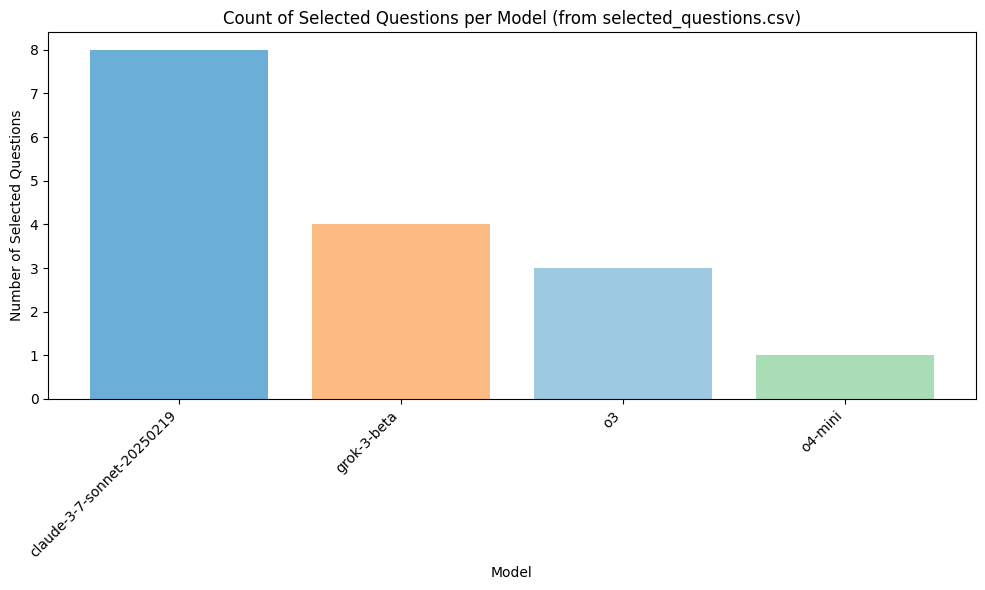

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the color palette
colors = ['#6BAED6', '#FDBB84', '#9ECAE1', '#A8DDB5']

# Read the CSV file
df = pd.read_csv('selected_questions.csv')

# Count questions per model
model_counts = df['model'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
# Cycle colors if there are more models than colors
bars = plt.bar(model_counts.index, model_counts.values, color=[colors[i % len(colors)] for i in range(len(model_counts))])
plt.xlabel('Model')
plt.ylabel('Number of Selected Questions')
plt.title('Count of Selected Questions per Model (from selected_questions.csv)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the chart
plt.show()

The test size isn't big, but the results align with my gut. Looking at the previous data I had an impression that claude-3-7 and grok-3 do better job on generating questions than chatgpt. Which shows also on this chart. However to make sure it would be good to perform much bigger tests.

Conducting bigger test could be costly but mostly because of the chatgpt pricing. While crafting this notebook i noticed that pricing of chatgpt in the prompts from this notebook was visibly higher, around 3-5 times more expensive than grok and claude but probably because o3 usage that is way more expensive than o4-mini, however o4-mini seems to be significantly weaker than the rest.

# Exam ready results

In [ ]:
import pandas as pd
import numpy as np

try:
    # Read the CSV file
    df = pd.read_csv('selected_questions.csv')

    # Check for required columns
    required_columns = ['excerpt_id', 'question', 'option_A', 'option_B', 'option_C', 'option_D', 'correct_answer']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("One or more required columns are missing from selected_questions.csv")

    # Select only the specified columns
    df = df[['excerpt_id', 'question', 'option_A', 'option_B', 'option_C', 'option_D', 'correct_answer']]

    # Function to shuffle options and update correct_answer
    def shuffle_options(row):
        options = [row['option_A'], row['option_B'], row['option_C'], row['option_D']]
        correct_answer = row['correct_answer']
        # Map correct_answer to index (A=0, B=1, C=2, D=3)
        try:
            correct_idx = {'A': 0, 'B': 1, 'C': 2, 'D': 3}[correct_answer]
        except KeyError:
            raise ValueError(f"Invalid correct_answer value '{correct_answer}' in row with question: {row['question']}")
        # Shuffle options
        shuffled_indices = np.random.permutation(4)
        shuffled_options = [options[i] for i in shuffled_indices]
        # Find new position of the correct answer
        new_correct_idx = np.where(shuffled_indices == correct_idx)[0][0]
        new_correct_answer = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}[new_correct_idx]
        # Return shuffled options and new correct_answer
        return pd.Series({
            'excerpt_id': row['excerpt_id'],
            'question': row['question'],
            'option_A': shuffled_options[0],
            'option_B': shuffled_options[1],
            'option_C': shuffled_options[2],
            'option_D': shuffled_options[3],
            'correct_answer': new_correct_answer
        })

    # Apply shuffling to each row
    df = df.apply(shuffle_options, axis=1)

    # Save the shuffled DataFrame to a new CSV
    df.to_csv('shuffled_selected_questions.csv', index=False)
    print("Shuffled questions saved to 'shuffled_selected_questions.csv'")

except FileNotFoundError:
    print("Error: selected_questions.csv not found")
except Exception as e:
    print(f"Error: {e}")

Shuffled questions saved to 'shuffled_selected_questions.csv'


# Quiz Questions

## Excerpt 1

1. **Design a resampling approach to assess linear regression variability.**  
   - A. Fit the model once and discard samples  
   - **B. Repeatedly sample data and compare model fits**  
   - C. Use a single sample for all assessments  
   - D. Ignore training data for external inputs  

2. **When implementing linear regression with resampling, what comparison would provide the most insight about model stability?**  
   - A. Running time between different sampling methods  
   - B. Size of the original training dataset  
   - C. Number of data points in each sample  
   - **D. Differences in regression coefficients across resampled fits**  

3. **Why might an analyst prefer resampling over a single model fit, according to the passage?**  
   - **A. It reveals how much fitted models can differ across possible training samples.**  
   - B. It removes the need for a separate test set entirely.  
   - C. It guarantees lower bias in parameter estimates.  
   - D. It ensures the training data contain no outliers.  

4. **Which primary benefit of resampling methods is highlighted in the excerpt?**  
   - **A. Estimating the variability of the model fit**  
   - B. Minimizing residual errors in the fit  
   - C. Reducing training time for large datasets  
   - D. Automatically selecting the best features  

---

## Excerpt 2

1. **In the context of statistical robustness and model variance, analyze why k-fold CV provides multiple MSE estimates.**  
   - **A. To assess how model performance varies across different subsets of data**  
   - B. To intentionally make the process more complex  
   - C. To display results in a visually appealing format  
   - D. To increase the programming challenge of implementation  

2. **For k = 6, how many distinct validation sets are employed in a complete k-fold CV cycle?**  
   - A. 12  
   - B. 1  
   - C. 5  
   - **D. 6**  

3. **What numerical relationship holds between folds, validation set size, and total observations in k-fold CV?**  
   - **A. Each fold contains approximately 1/k of total observations**  
   - B. The first fold is always largest to establish baseline performance  
   - C. Folds get progressively smaller as k increases  
   - D. Each fold must contain exactly the same number of observations  

4. **How many estimates of test error does k-fold CV produce?**  
   - **A. k estimates**  
   - B. One combined estimate  
   - C. One estimate per observation  
   - D. k-1 estimates  

---

## Excerpt 3

1. **Design a scenario where a marketing study would shift from unsupervised to supervised learning. What key information would enable this transition?**  
   - A. Increasing the sample size of potential customers  
   - B. Collection of additional predictor variables about customers  
   - **C. Acquiring knowledge about each customer's actual spending patterns**  
   - D. Developing more sophisticated clustering algorithms  

2. **Evaluate why cluster analysis is categorized as unsupervised learning rather than supervised learning.**  
   - A. It produces less accurate results than supervised methods  
   - B. It only works with categorical predictor variables  
   - **C. It operates without response variables to guide the analysis**  
   - D. It requires more computational resources than supervised methods  

3. **Design a scenario where clustering could identify customer groups.**  
   - A. Predicting spending with a response variable and regression  
   - B. Fitting a supervised model with known customer groups  
   - C. Ignoring variables to predict future responses  
   - **D. Using zip code and income to group customers without spending data**  

4. **What distinguishes supervised learning from unsupervised learning?**  
   - **A. Supervised learning has a response variable, while unsupervised does not.**  
   - B. Supervised learning is blind, while unsupervised is guided.  
   - C. Supervised learning uses clustering, while unsupervised uses regression.  
   - D. Supervised learning lacks predictors, while unsupervised uses them.  

---

## Excerpt 4

1. **Design a strategy to improve model selection when p is large. Which approach balances adding and removing variables?**  
   - A. Null model testing, as it avoids variable selection  
   - B. Backward selection, as it only removes variables  
   - C. Forward selection, as it only adds variables  
   - **D. Mixed selection, as it combines forward addition and backward removal**  

2. **Analyze the primary disadvantage of forward selection compared to mixed selection:**  
   - A. Forward selection cannot be used when p > n  
   - **B. Forward selection might include variables early that later become redundant**  
   - C. Forward selection requires more computational resources  
   - D. Forward selection cannot handle categorical predictors  

3. **You have p > n and desire a method that can add and later drop predictors. Which method fits?**  
   - A. Backward selection  
   - **B. Mixed selection**  
   - C. Adjusted R² ranking  
   - D. Forward selection  

4. **What is the main limitation of backward selection in variable selection?**  
   - A. It only removes variables with p-values below a threshold  
   - B. It always starts with the null model  
   - C. It requires computing the F-statistic first  
   - **D. It cannot be used when p > n**  
